# Volume 3: Kalman Filter
    Benj McMullin
    Math 405
    3/5/2024

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Problem 1
Begin implementing a KalmanFilter class by writing an initialization method that stores the transition and observation models, noise covariances, and control vector.

## Problem 3
Add a method evolve() to your KalmanFilter class to generate a state and observation sequence by evolving the system from a given initial state.

## Problem 4
Add code to your KalmanFilter class to estimate a state sequence corresponding to a given observation sequence and initial state estimate by implementing the estimate() method.

## Problem 6
Add a function predict() to your class that predicts the next $k$ states given a current state estimate but in the absence of observations.

## Problem 8
Add a function rewind() to your class that rewinds the system from a given state estimate, returning predictions for the previous states. 

In [3]:

class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        # Store the matrices
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
    
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        # Initialize arrays to store state vectors and observations
        states = np.zeros((len(x0), N))  # Array to store state vectors
        obs = np.zeros((np.shape(self.H)[0], N))  # Array to store observations

        # Calculate initial observation based on measurement matrix H and initial state x0
        obs0 = self.H @ x0

        # Store initial state and observation
        states[:, 0] = x0
        obs[:, 0] = obs0

        # Iterate over time steps and evolve the system
        for n in range(1, N):
            # Propagate the state forward using the transition matrix F and control input u
            x1 = self.F @ x0 + self.u + np.random.multivariate_normal(np.zeros(np.shape(self.Q)[0]), self.Q)
            
            # Generate the next observation based on the state and measurement matrix H
            obs1 = self.H @ x1 + np.random.multivariate_normal(np.zeros(np.shape(self.R)[0]), self.R)
            
            # Store the propagated state and observation
            states[:, n] = x1
            obs[:, n] = obs1
            
            # Update the current state and observation for the next iteration
            x0 = x1
            obs0 = obs1

        # Return the arrays containing all state vectors and observations
        return states, obs     

    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        # Initialize array to store state estimates
        estimates = np.zeros((len(x0), np.shape(z)[1]))

        # Set the initial estimate
        estimates[:, 0] = x0

        # Iterate over time steps to perform prediction and update steps
        for n in range(1, np.shape(z)[1]):
            # Predict step
            xhat1 = self.F @ x0 + self.u  # Predicted state estimate
            Pk = self.F @ P0 @ self.F.T   # Predicted error covariance
            
            # Update step
            yhatk = z[:, n] - self.H @ xhat1        # Innovation or measurement residual
            Sk = self.H @ Pk @ self.H.T + self.R    # Innovation covariance
            Kk = Pk @ self.H.T @ np.linalg.inv(Sk)  # Optimal Kalman gain
            x0 = xhat1 + Kk @ yhatk                 # Updated state estimate
            P0 = (np.eye(np.shape(P0)[0]) - Kk @ self.H) @ Pk  # Updated error covariance
            
            # Store the current state estimate
            estimates[:, n] = x0

        # Return the array containing all state estimates
        return estimates
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        # Initialize array to store predicted values
        predicted = np.zeros((len(x), k))

        # Set the initial predicted value
        predicted[:, 0] = x

        # Iterate over time steps and update predicted values
        for i in range(1, k):
            x1 = self.F @ x + self.u  # Update predicted value using state transition matrix and control input
            predicted[:, i] = x1      # Store the predicted value
            x = x1                    # Update the current state to be used in the next iteration

        # Return the array containing all predicted values
        return predicted

    
    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        # Initialize array to store rewinded values
        rewinded = np.zeros((len(x), k))

        # Set the last value of the rewinded array
        rewinded[:, -1] = x

        # Iterate backwards and update rewinded values
        for i in range(1, k):
            xnew = np.linalg.inv(self.F) @ (x - self.u)  # Compute new value by inverting the state transition matrix
            rewinded[:, k - (i + 1)] = xnew              # Store the rewinded value
            x = xnew                                     # Update the current state for the next iteration

        # Return the array containing all rewinded values
        return rewinded
 


## Problem 2 

Work out the transition and observation models $F$ and $H$, along with the control vector $\mathbf{u}$, corresponding to the projectile. 
Assume that the noise covariances are given by 

$\begin{align*}
    Q &= 0.1 \cdot I_4 \\
    R &= 5000 \cdot I_2.
\end{align*}$

Instantiate a KalmanFilter object with these values.

In [4]:
# Initialize state transition matrix F
F = np.array([[1, 0, 0.1, 0],
              [0, 1, 0, 0.1],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

# Initialize control input vector u
u = np.array([0, 0, 0, -0.98])

# Initialize process noise covariance matrix Q
Q = 0.1 * np.eye(4)

# Initialize observation noise covariance matrix R
R = 5000 * np.eye(2)

# Initialize observation matrix H
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# Create an instance of the KalmanFilter class with the initialized parameters
kf = KalmanFilter(F, Q, H, R, u)

## Problem 3

Simulate the true and observed trajectory of a projectile with initial state

$\begin{equation*}
x_0 = \begin{pmatrix} 0 \\ 0 \\ 300 \\ 600 \end{pmatrix}
\end{equation*}$

In [5]:
# Generate the first 1250 states and observations
x0 = np.array([0,0,300,600])
states, obs = kf.evolve(x0,1250)

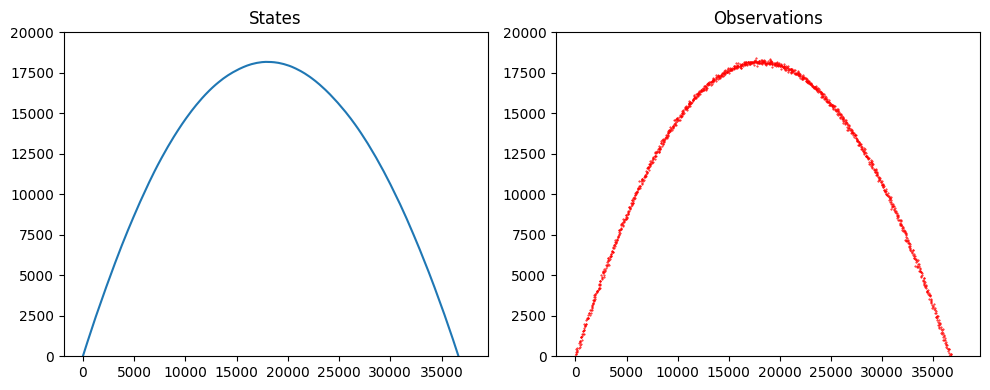

In [6]:
# Plot it
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(states[0,:], states[1,:])
plt.title("States")
plt.ylim(0,20000)

plt.subplot(122)
plt.scatter(obs[0,:], obs[1,:], s=.2, c='r')
plt.title("Observations")
plt.ylim(0,20000)

plt.tight_layout()

plt.show()

## Problem 5

Calculate an initial state estimate $\hat{\mathbf{x}}_{200}$ as follows: For the horizontal and vertical positions, simply use the observed position at time 200. 
For the velocity, compute the average velocity between the observations $\mathbf{z}_k$ and $\mathbf{z}_{k+1}$ for $k = 200,\dots, 208$, then average these 9 values and take this as the initial velocity estimate.
Using the initial state estimate, $P_{200} = 10^6\cdot Q$, and your Kalman Filter, compute the next 600 state estimates, i.e. compute $\hat{\mathbf{x}}_{201},\dots,\hat{\mathbf{x}}_{800}$. 
Plot these state estimates as a smooth green curve together with the radar observations (as red dots) and the entire true state sequence (as
a blue curve). 
Zoom in to see how well it follows the true path. 

In [7]:
# Initialize the initial state estimate and error covariance
x0 = states[:,200]
x0[2], x0[3] = np.mean(np.diff(obs[0,200:209])), np.mean(np.diff(obs[0,200:209]))

# Initialize the initial error covariance
P0 = 10e6*kf.Q

# Perform the estimation
estimates = kf.estimate(x0, P0, obs[:,201:801])

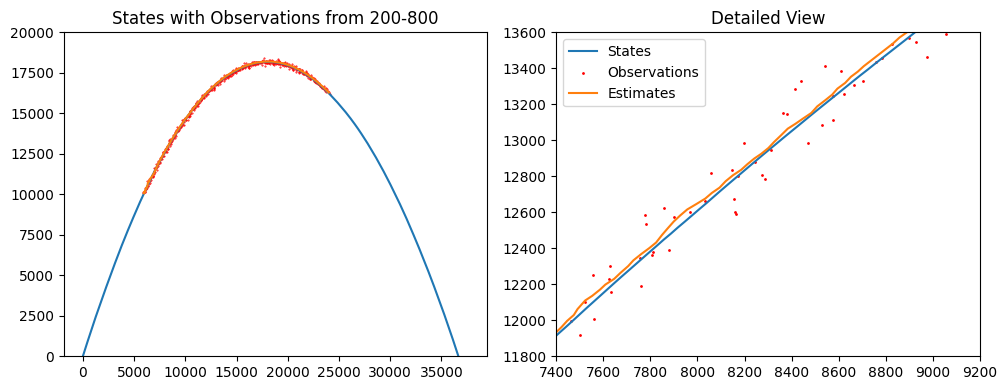

In [8]:
# Plot it
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(states[0,:], states[1,:])
plt.scatter(obs[0,200:801], obs[1,200:801], s=.2, c='r')
plt.plot(estimates[0,:], estimates[1,:])
plt.title("States with Observations from 200-800")
plt.ylim(0,20000)

plt.subplot(122)
plt.plot(states[0,:], states[1,:], label="States")
plt.scatter(obs[0,200:801], obs[1,200:801], s=1, c='r', label="Observations")
plt.plot(estimates[0,:], estimates[1,:], label="Estimates")
plt.title("Detailed View")
plt.xlim(7400,9200)
plt.ylim(11800,13600)

plt.legend()
plt.tight_layout()

plt.show()

## Problem 7

Using the final state estimate $\hat{\mathbf{x}}_{800}$ that you obtained in Problem 5, predict the future states of the projectile until it hits the ground. 
Predicting approximately the next 450 states should be sufficient.
Plot the actual state sequence together with the predicted state sequence (as a yellow curve), and observe how near the prediction is to the actual point of impact.

In [9]:
# Initialize the initial state estimate and error covariance
x = estimates[:,-1]
k = 450

# Perform the prediction
predictions = kf.predict(x,k)

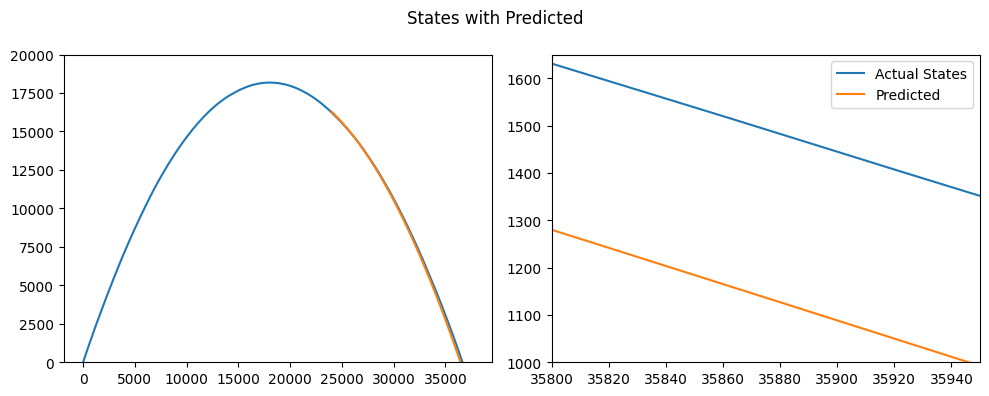

In [16]:
# Plot it
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(states[0,:], states[1,:])
plt.plot(predictions[0,:], predictions[1,:])
plt.suptitle("States with Predicted")
plt.ylim(0,20000)

plt.subplot(122)
plt.plot(states[0,:], states[1,:], label="Actual States")
plt.plot(predictions[0,:], predictions[1,:], label="Predicted")
# plt.title("Detailed View")
plt.xlim(35800, 35950)
plt.ylim(1000,1650)

plt.legend()
plt.tight_layout()

plt.show()

## Problem 9

Using your state estimate $\hat{\mathbf{x}}_{250}$, predict the point of origin of the projectile along with all states leading up to time step 250. 
Note that you may have to take a few extra time steps to predict the point of origin. 
Plot these predicted states (in green) together with the original state sequence. 
Zoom in to see how accurate your prediction is. 
Repeat the prediction starting with $\hat{\mathbf{x}}_{600}$. 
Compare to the previous results. 
Which is better? 
Why?

In [17]:
# Initialize for 250
x = estimates[:,250]
k = 451

# Perform the prediction
rewinded = kf.rewind(x,k)

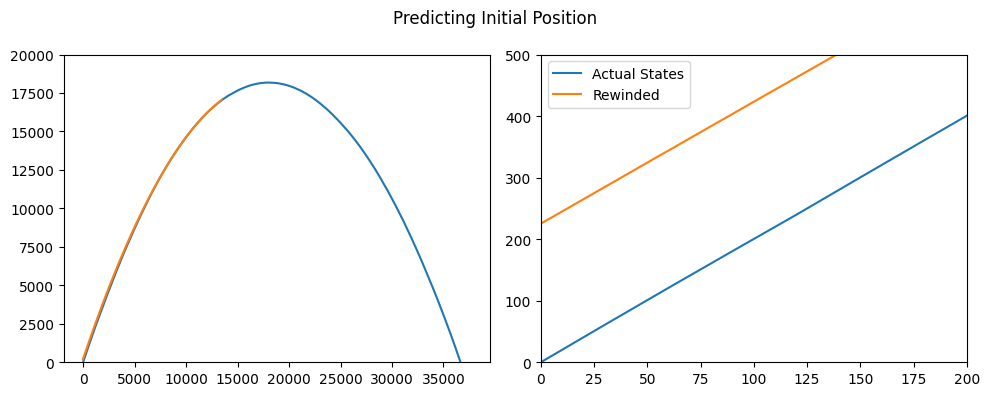

In [22]:
# Plot it
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(states[0,:], states[1,:])
plt.plot(rewinded[0,:], rewinded[1,:])
plt.suptitle("Predicting Initial Position")
plt.ylim(0,20000)

plt.subplot(122)
plt.plot(states[0,:], states[1,:], label="Actual States")
plt.plot(rewinded[0,:], rewinded[1,:], label="Rewinded")
plt.xlim(0, 200)
plt.ylim(0,500)

plt.legend()
plt.tight_layout()

plt.show()

In [23]:
# Initialize for 600
x = estimates[:,599]
k = 800

# Perform the prediction
rewinded = kf.rewind(x,k)
print(rewinded[:,0])

[-79.86230541 324.66861592 301.44926751 590.75491569]


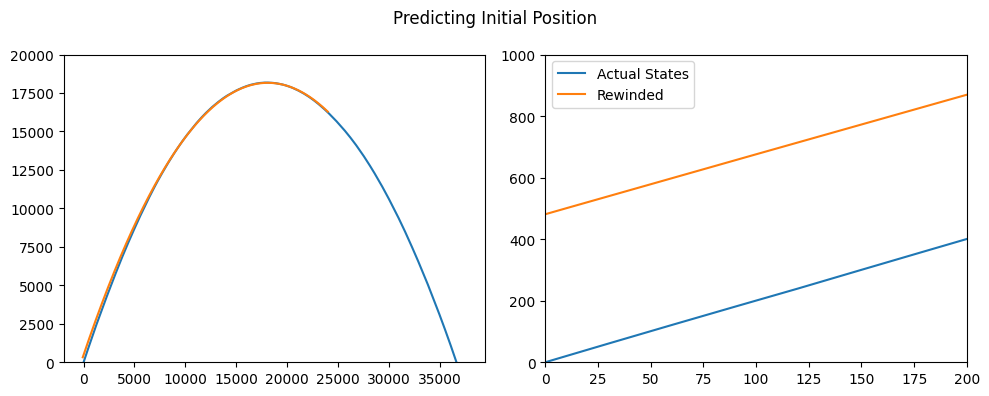

In [27]:
# Plot it
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(states[0,:], states[1,:])
plt.plot(rewinded[0,:], rewinded[1,:])
plt.suptitle("Predicting Initial Position")
plt.ylim(0,20000)

plt.subplot(122)
plt.plot(states[0,:], states[1,:], label="Actual States")
plt.plot(rewinded[0,:], rewinded[1,:], label="Rewinded")
plt.xlim(0, 200)
plt.ylim(0,1000)

plt.legend()
plt.tight_layout()

plt.show()